1. Downlowd the cleaned data

In [ ]:
import pandas as pd

df = pd.read_csv(path)

df_raw = df.copy()       # full untouched data
df = df_raw.copy()       # new working copy



Run GMM and choose the best number of clusters

In [52]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 1. Select features for model 1
features_ord = [
    'price', 'odometer', 'year',
    'lat', 'long',
    'condition', 'manufacturer', 'cylinders'
]

num_cols_ord = ['price', 'odometer', 'year', 'lat', 'long']
cat_cols_ord = ['condition', 'manufacturer', 'cylinders']

X_ord = df_raw[features_ord].copy()

numeric_pipe_ord = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe_ord = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder())
])

preprocess_ord = ColumnTransformer([
    ("num", numeric_pipe_ord, num_cols_ord),
    ("cat", categorical_pipe_ord, cat_cols_ord)
])

X_ord_proc = preprocess_ord.fit_transform(X_ord)

bics = []
models = []

for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_ord_proc)
    bics.append(gmm.bic(X_ord_proc))
    models.append(gmm)

best_k = bics.index(min(bics)) + 2
best_gmm_ord = models[bics.index(min(bics))]

print("Best number of clusters (ordinal model):", best_k)

df_raw['cluster_gmm_ord'] = best_gmm_ord.predict(X_ord_proc)


Best number of clusters (ordinal model): 9


Graph the clusters using the three dimensions: Price, Odometer, and Year

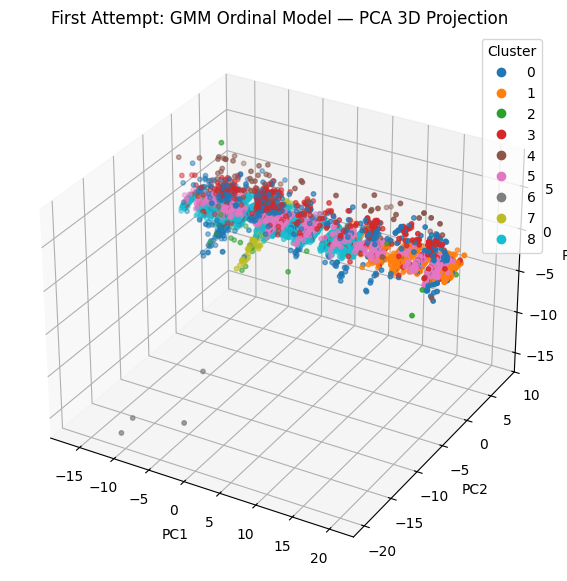

In [60]:
from sklearn.decomposition import PCA

# Use the SAME processed data gmm used
X_vis = X_ord_proc   # <- already imputed, scaled, encoded

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_vis)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=df_raw['cluster_gmm_ord'],
    cmap='tab10',
    s=10
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("First Attempt: GMM Ordinal Model — PCA 3D Projection")

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


Compare GMM and k means

In [97]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df_raw['cluster_kmeans_ord'] = kmeans.fit_predict(X_ord_proc)


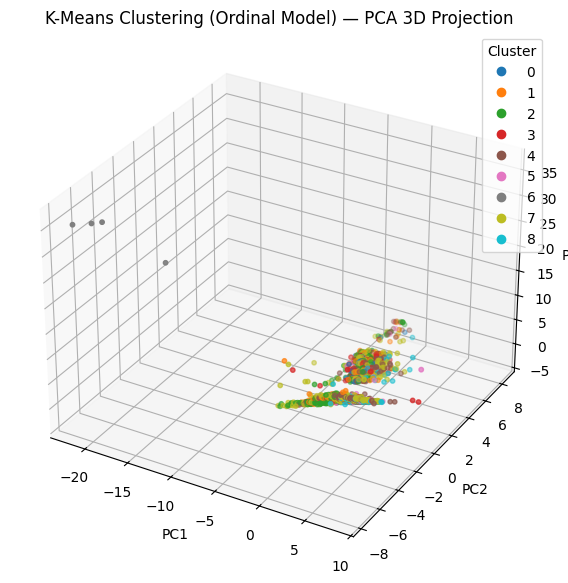

In [98]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=df_raw['cluster_kmeans_ord'],
    cmap='tab10',
    s=10
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("K-Means Clustering (Ordinal Model) — PCA 3D Projection")

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


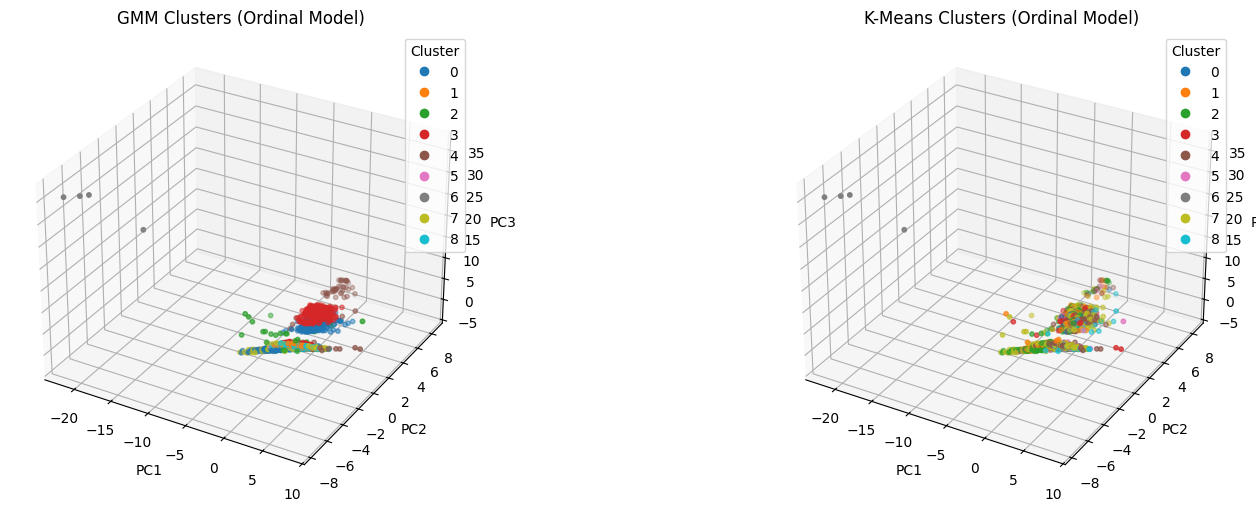

In [99]:
fig = plt.figure(figsize=(18, 6))

# ---- GMM ----
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=df_raw['cluster_gmm_ord'], cmap='tab10', s=10
)
ax1.set_title("GMM Clusters (Ordinal Model)")
ax1.set_xlabel("PC1"); ax1.set_ylabel("PC2"); ax1.set_zlabel("PC3")
ax1.legend(*sc1.legend_elements(), title="Cluster")

# ---- KMEANS ----
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=df_raw['cluster_kmeans_ord'], cmap='tab10', s=10
)
ax2.set_title("K-Means Clusters (Ordinal Model)")
ax2.set_xlabel("PC1"); ax2.set_ylabel("PC2"); ax2.set_zlabel("PC3")
ax2.legend(*sc2.legend_elements(), title="Cluster")

plt.show()


show vintage car cluster

In [96]:
df[df['cluster_gmm_ord'] == 3]


,state,price,condition,cylinders,fuel,manufacturer,drive,year,title_status,odometer,paint_color,lat,long,cluster_gmm_ord,cluster_gmm_ohe,lat_clean,long_clean,cluster_gmm_state_ohe
10,ca,11995,NaN,NaN,other,gmc,fwd,2007,clean,192493.0,black,3409929.0,-117.431150,3,4,36.116203,-119.681564,1
28,fl,8488,excellent,4 cylinders,gas,hyundai,fwd,2008,clean,70816.0,black,2898219.0,-80.672779,3,3,27.766279,-81.686783,4
29,tn,8995,NaN,4 cylinders,gas,nissan,NaN,2011,clean,106540.0,blue,36127.0,-86.560000,3,5,35.747845,-86.692345,10
55,nc,27995,excellent,NaN,hybrid,lexus,NaN,2016,clean,52278.0,NaN,3627601.0,-78.924120,3,3,35.630066,-79.806419,0
62,or,12877,NaN,6 cylinders,NaN,cadillac,NaN,2011,clean,73120.0,silver,4476513.0,-123.150156,3,3,44.572021,-122.070938,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,nm,10200,NaN,NaN,gas,honda,NaN,2013,clean,109000.0,NaN,35717.0,-106.509000,3,1,34.840515,-106.248482,8
8439,mi,6495,excellent,4 cylinders,gas,dodge,fwd,2013,clean,167000.0,black,4303988.0,-82.440054,3,3,43.326618,-84.536095,0
8449,tx,2150,excellent,6 cylinders,gas,ford,fwd,1998,clean,170000.0,NaN,3177697.0,-97.688918,3,3,31.054487,-97.563461,10
8469,oh,26999,excellent,6 cylinders,gas,jeep,4wd,2014,clean,78502.0,NaN,4138965.0,-81.575742,3,3,40.388783,-82.764915,0


Second Attempt: Below is when car manufacureres are one hot encoded, adding many dimenstions

In [68]:
import numpy as np
from sklearn.mixture import GaussianMixture

def pick_best_gmm(X, k_min=2, k_max=15, covariance="tied"):
    bics = []
    models = []
    
    for k in range(k_min, k_max+1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=covariance,
            random_state=42
        )
        gmm.fit(X)
        bics.append(gmm.bic(X))
        models.append(gmm)
    
    best_index = np.argmin(bics)
    best_k = best_index + k_min
    best_model = models[best_index]
    
    print(f"Best number of clusters = {best_k}")
    
    return best_model, best_k, bics


In [69]:
X_ohe_proc = preprocess_ohe.fit_transform(X_ohe)
best_model_ohe, best_k_ohe, bics_ohe = pick_best_gmm(X_ohe_proc)

df_raw["cluster_gmm_ohe"] = best_model_ohe.predict(X_ohe_proc)


Best number of clusters = 15


C:\Users\ibrah\AppData\Local\Temp\ipykernel_59344\216232143.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab20')  # has 20 distinct colors


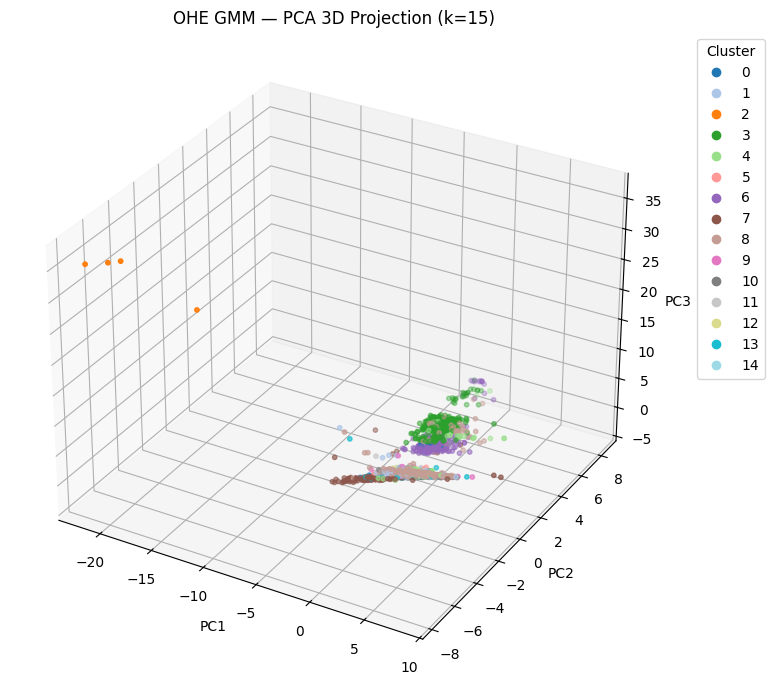

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap

labels = df_raw['cluster_gmm_ohe'].to_numpy()
k = len(np.unique(labels))  # should be 15

# 1) Use the correct data for this model
X_vis = X_ohe_proc  # processed data for OHE model
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_vis)

# 2) Build a colormap with k discrete colors
base_cmap = cm.get_cmap('tab20')  # has 20 distinct colors
cmap = ListedColormap(base_cmap(np.linspace(0, 1, k)))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=labels,
    cmap=cmap,
    s=10
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f"Second Attempt: OHE GMM — PCA 3D Projection (k={k})")

# 3) Manual legend: one color per cluster id
handles = []
legend_labels = []
for i in range(k):
    handles.append(plt.Line2D([], [], marker='o', linestyle='', color=cmap(i), markersize=6))
    legend_labels.append(str(i))

ax.legend(handles, legend_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Make a report of the clusteres generated (ohe only)

In [25]:
num_cols = ['price','odometer','year','lat','long']
cluster_means = df2.groupby('cluster_ohe')[num_cols].mean()
cluster_stds = df2.groupby('cluster_ohe')[num_cols].std()


Plot 1 a report for each numeric feature

Plot 2 a report for each numeric feature

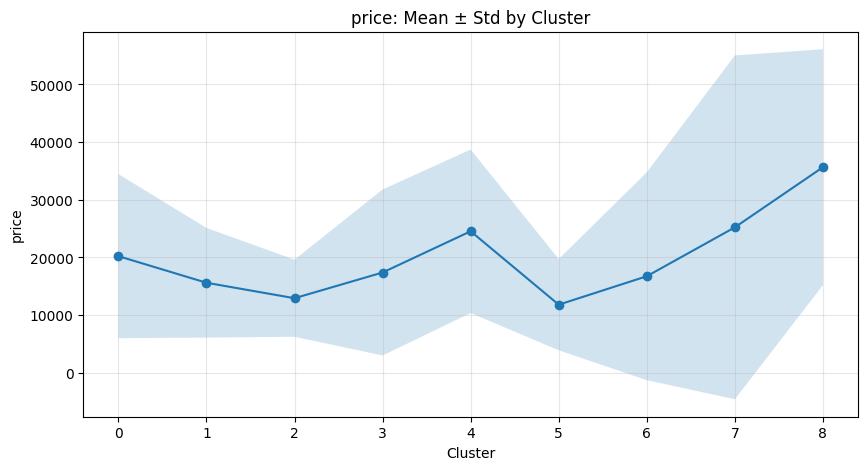

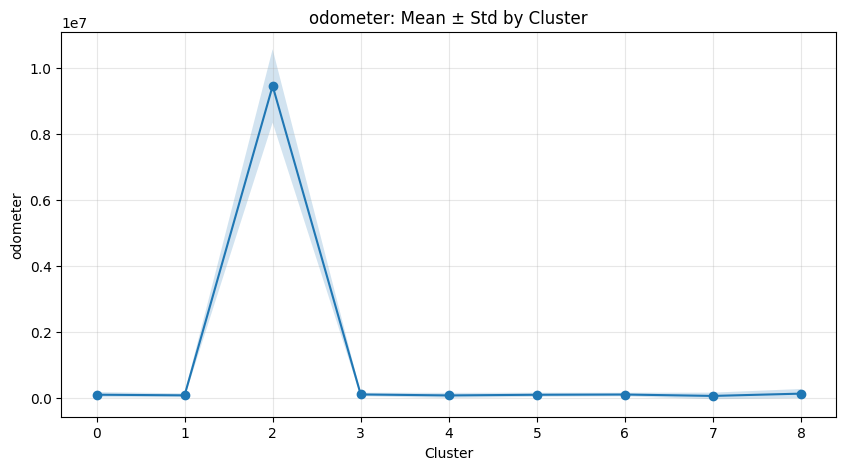

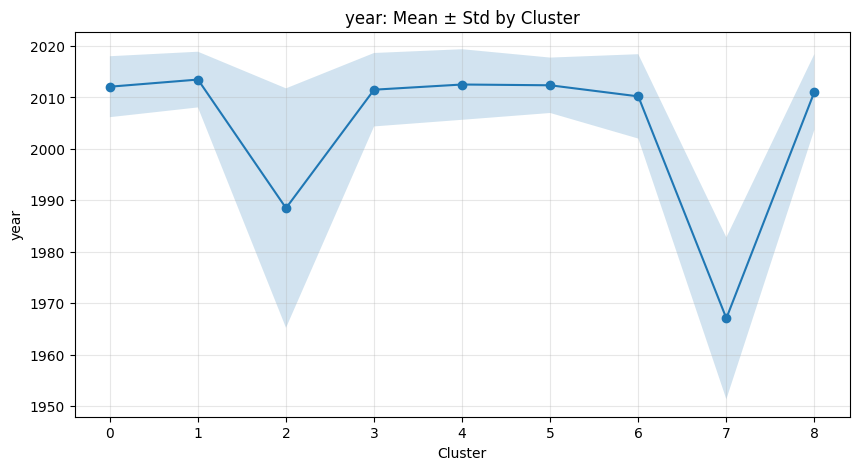

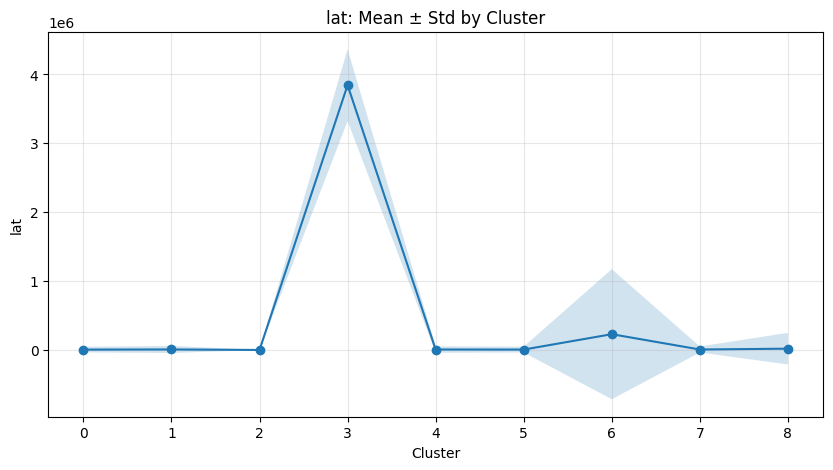

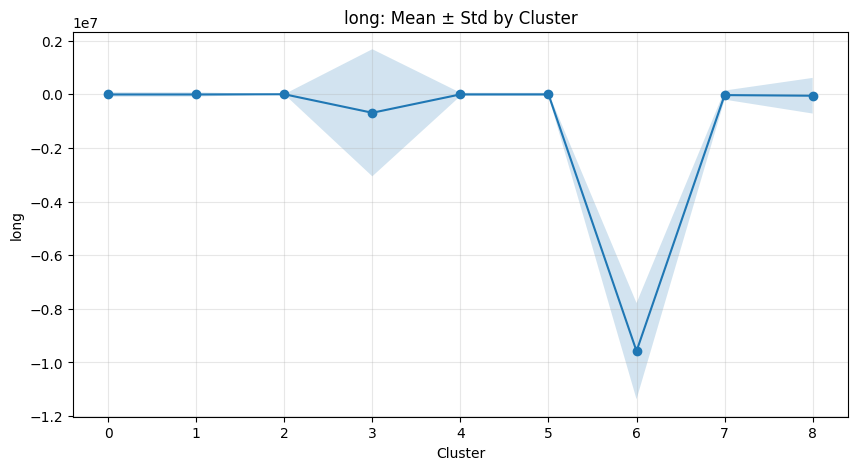

In [27]:
for col in num_cols:
    means = df2.groupby('cluster_ohe')[col].mean()
    stds = df2.groupby('cluster_ohe')[col].std()

    plt.figure(figsize=(10,5))
    plt.plot(means.index, means.values, marker='o')
    plt.fill_between(means.index,
                     means - stds,
                     means + stds,
                     alpha=0.2)
    plt.title(f"{col}: Mean ± Std by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.grid(alpha=0.3)
    plt.show()


Plot 3 a report for each numeric feature

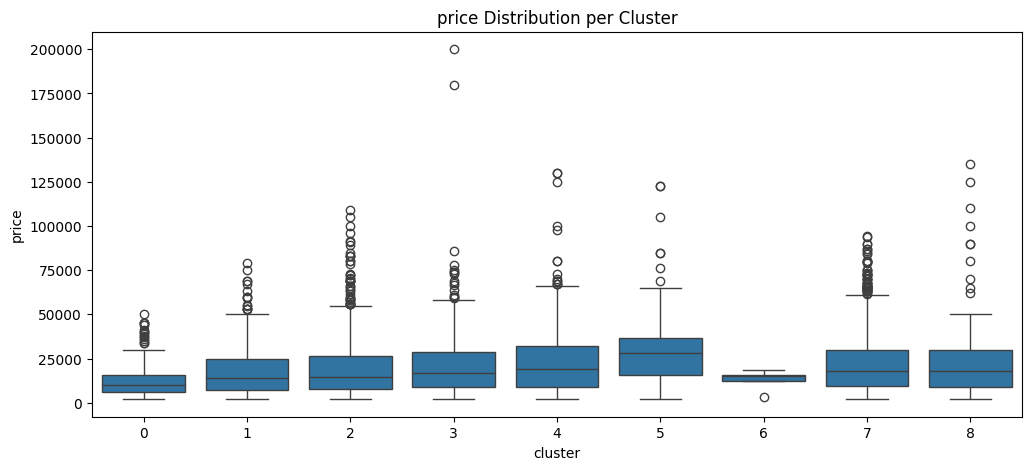

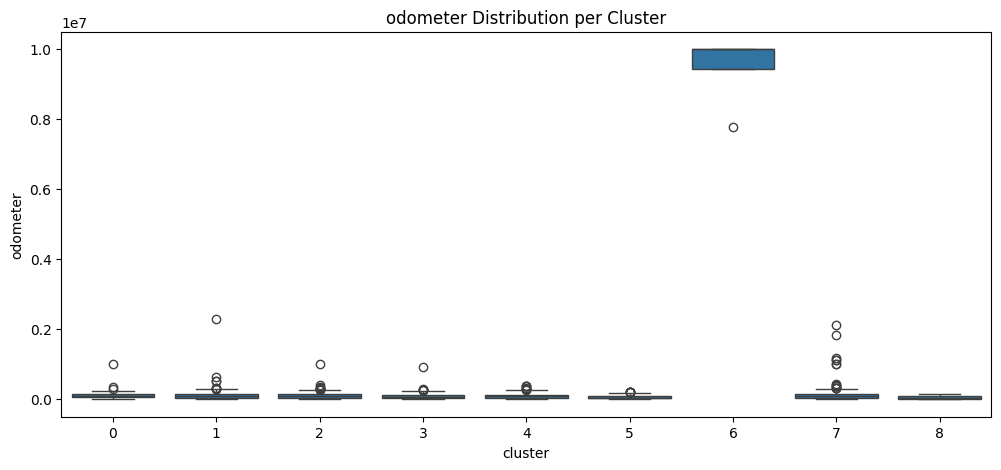

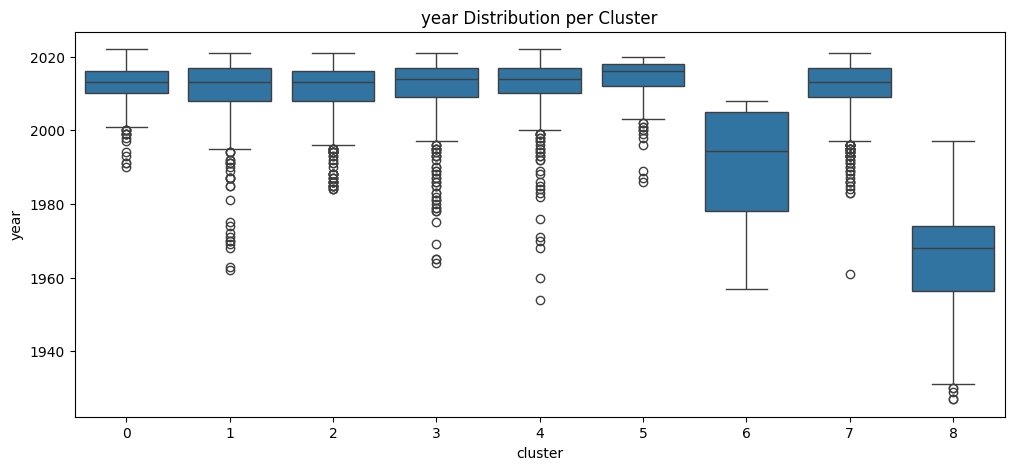

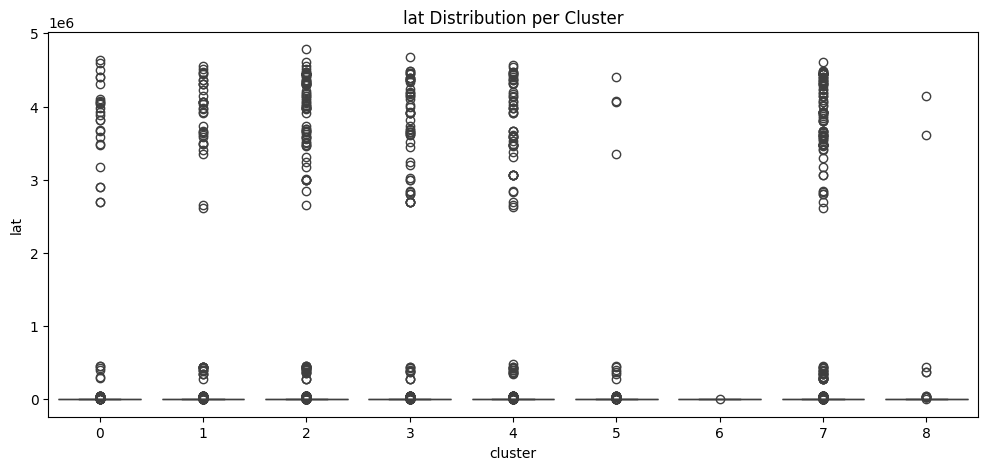

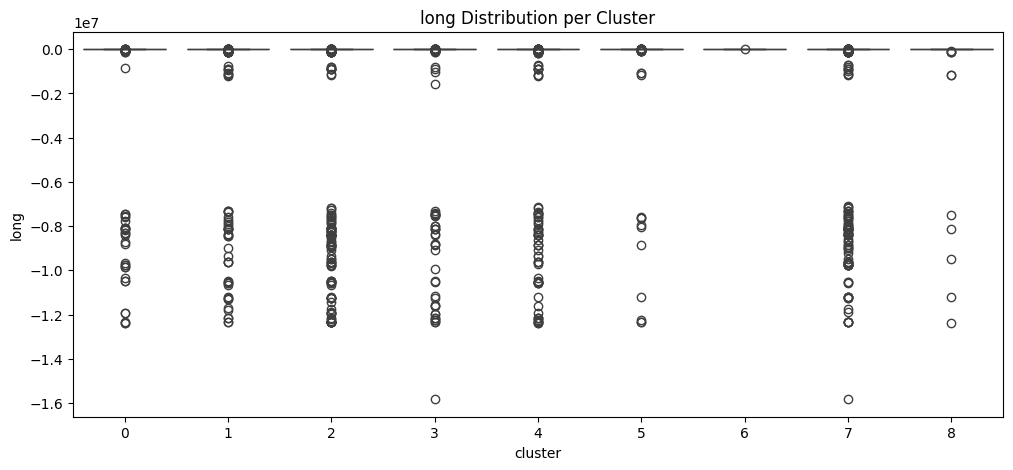

In [28]:
import seaborn as sns

for col in num_cols:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='cluster', y=col)
    plt.title(f"{col} Distribution per Cluster")
    plt.show()


In [79]:
df = df_raw  # or df = df_raw.copy() if you plan to modify it
print([c for c in df.columns if 'cluster' in c])


['cluster_gmm_ord', 'cluster_gmm_ohe', 'cluster_gmm_state_ohe']


Fix coordinates with state  average

In [62]:
state_centroids = {
    "al": (32.806671, -86.791130),
    "ak": (61.370716, -152.404419),
    "az": (33.729759, -111.431221),
    "ar": (34.969704, -92.373123),
    "ca": (36.116203, -119.681564),
    "co": (39.059811, -105.311104),
    "ct": (41.597782, -72.755371),
    "de": (39.318523, -75.507141),
    "fl": (27.766279, -81.686783),
    "ga": (33.040619, -83.643074),
    "hi": (21.094318, -157.498337),
    "id": (44.240459, -114.478828),
    "il": (40.349457, -88.986137),
    "in": (39.849426, -86.258278),
    "ia": (42.011539, -93.210526),
    "ks": (38.526600, -96.726486),
    "ky": (37.668140, -84.670067),
    "la": (31.169546, -91.867805),
    "me": (44.693947, -69.381927),
    "md": (39.063946, -76.802101),
    "ma": (42.230171, -71.530106),
    "mi": (43.326618, -84.536095),
    "mn": (45.694454, -93.900192),
    "ms": (32.741646, -89.678696),
    "mo": (38.456085, -92.288368),
    "mt": (46.921925, -110.454353),
    "ne": (41.125370, -98.268082),
    "nv": (38.313515, -117.055374),
    "nh": (43.452492, -71.563896),
    "nj": (40.298904, -74.521011),
    "nm": (34.840515, -106.248482),
    "ny": (42.165726, -74.948051),
    "nc": (35.630066, -79.806419),
    "nd": (47.528912, -99.784012),
    "oh": (40.388783, -82.764915),
    "ok": (35.565342, -96.928917),
    "or": (44.572021, -122.070938),
    "pa": (40.590752, -77.209755),
    "ri": (41.680893, -71.511780),
    "sc": (33.856892, -80.945007),
    "sd": (44.299782, -99.438828),
    "tn": (35.747845, -86.692345),
    "tx": (31.054487, -97.563461),
    "ut": (40.150032, -111.862434),
    "vt": (44.045876, -72.710686),
    "va": (37.769337, -78.169968),
    "wa": (47.400902, -121.490494),
    "wv": (38.491226, -80.954453),
    "wi": (44.268543, -89.616508),
    "wy": (42.755966, -107.302490),
    "dc": (38.9072, -77.0369),
}

df_raw['state'] = df_raw['state'].str.lower()

def apply_state_coords(row):
    s = row['state']
    if s in state_centroids:
        return pd.Series(state_centroids[s])
    return pd.Series([np.nan, np.nan])

df_raw[['lat_clean', 'long_clean']] = df_raw.apply(apply_state_coords, axis=1)

Third Attempt: fixing coordinates with states, using ('lat_clean' and 'long_clean')
This takes care of cluster 2 (outlier)

In [71]:
import numpy as np
from sklearn.mixture import GaussianMixture

def pick_best_gmm(X, k_min=2, k_max=15, covariance="tied"):
    bics = []
    models = []
    
    for k in range(k_min, k_max+1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=covariance,
            random_state=42
        )
        gmm.fit(X)
        bics.append(gmm.bic(X))
        models.append(gmm)
    
    best_index = np.argmin(bics)
    best_k = best_index + k_min
    best_model = models[best_index]
    
    print(f"Best number of clusters = {best_k}")
    
    return best_model, best_k, bics


In [72]:
X_state_proc = preprocess_state.fit_transform(X_state)
best_model_state, best_k_state, bics_state = pick_best_gmm(X_state_proc)

df_raw["cluster_gmm_state_ohe"] = best_model_state.predict(X_state_proc)


Best number of clusters = 11


Graphing the third attempt (it doesn't seem like an improvement)

C:\Users\ibrah\AppData\Local\Temp\ipykernel_59344\2630097460.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab20')  # has 20 distinct colors


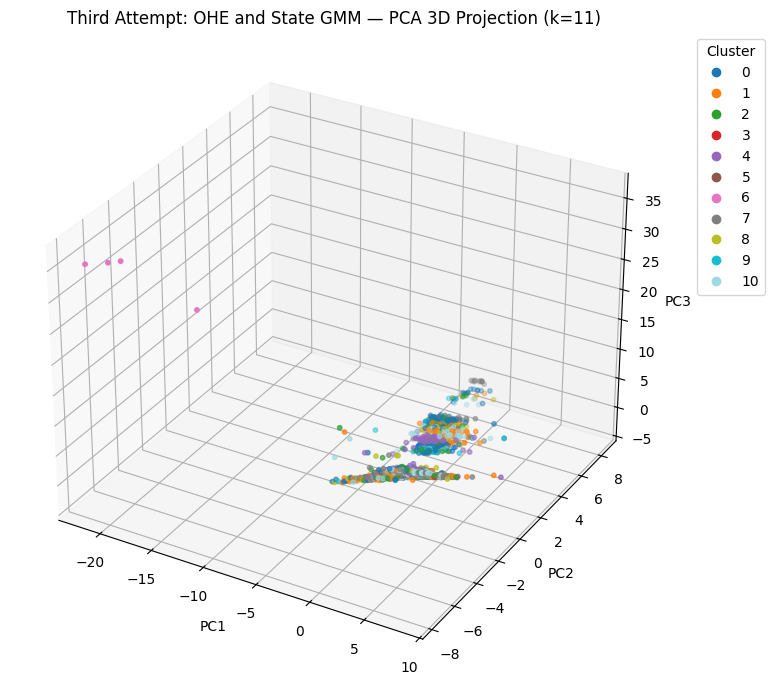

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap

labels = df_raw['cluster_gmm_state_ohe'].to_numpy()
k = len(np.unique(labels))  # should be 15

# 1) Use the correct data for this model
X_vis = X_ohe_proc  # processed data for OHE model
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_vis)

# 2) Build a colormap with k discrete colors
base_cmap = cm.get_cmap('tab20')  # has 20 distinct colors
cmap = ListedColormap(base_cmap(np.linspace(0, 1, k)))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=labels,
    cmap=cmap,
    s=10
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f"Third Attempt: OHE and State GMM — PCA 3D Projection (k={k})")

# 3) Manual legend: one color per cluster id
handles = []
legend_labels = []
for i in range(k):
    handles.append(plt.Line2D([], [], marker='o', linestyle='', color=cmap(i), markersize=6))
    legend_labels.append(str(i))

ax.legend(handles, legend_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


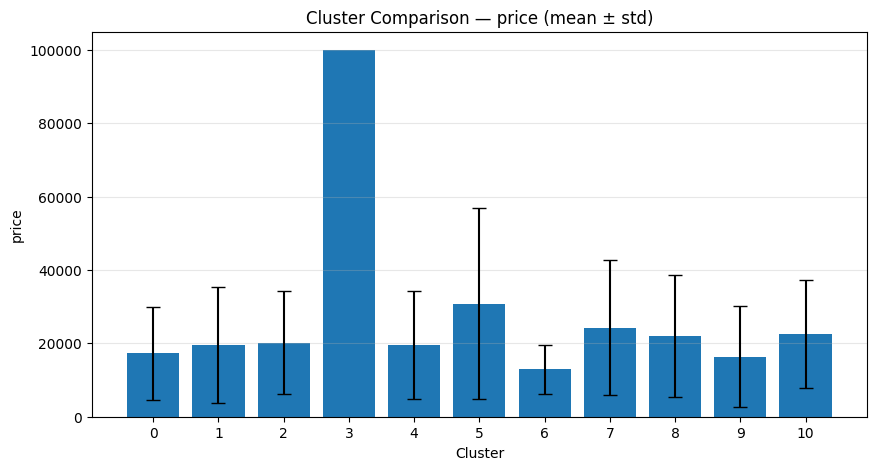

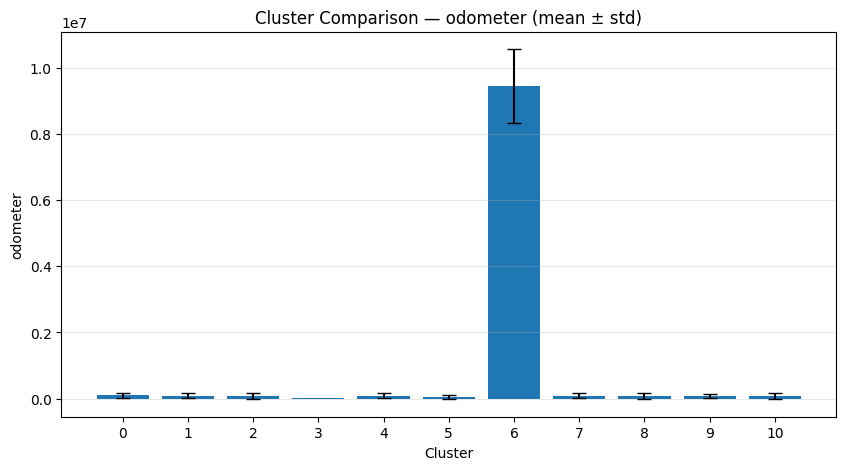

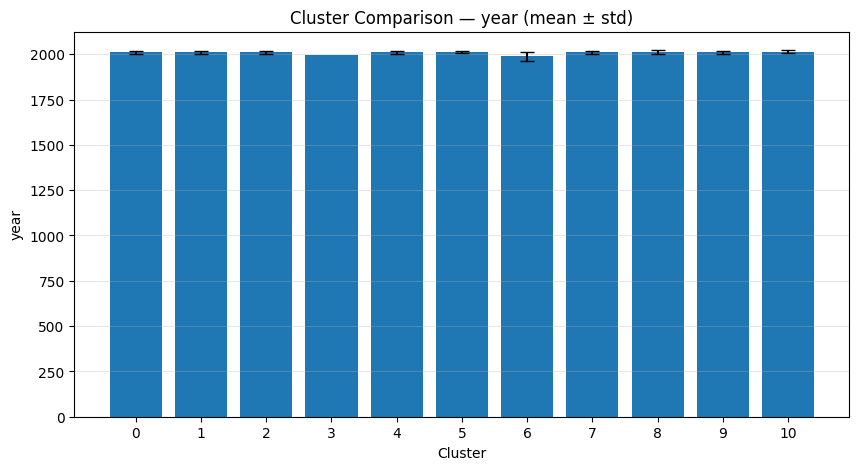

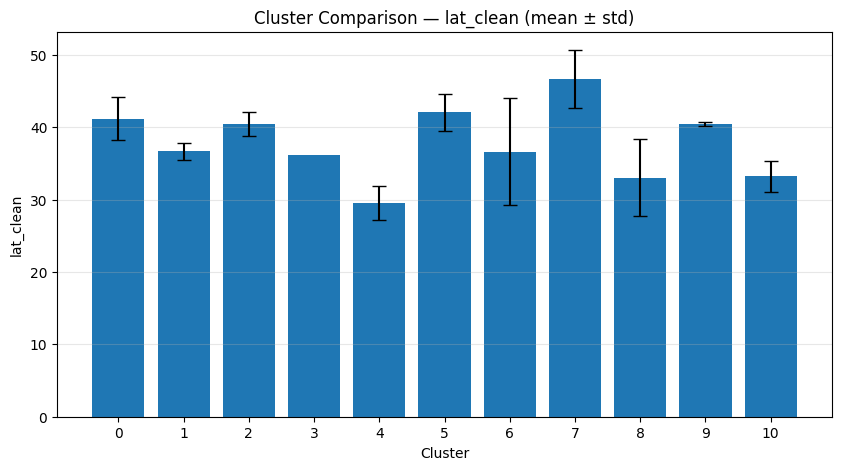

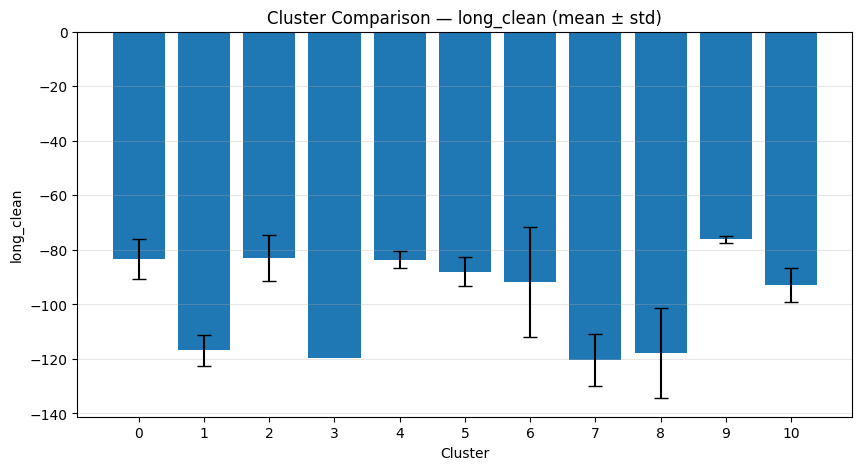

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# numeric columns for the third model
num_cols = ['price','odometer','year','lat_clean','long_clean']

cluster_col = 'cluster_gmm_state_ohe'  # <-- update this if needed

cluster_means = df.groupby(cluster_col)[num_cols].mean()
cluster_stds  = df.groupby(cluster_col)[num_cols].std()

for col in num_cols:
    means = cluster_means[col]
    stds  = cluster_stds[col]

    plt.figure(figsize=(10,5))
    plt.bar(means.index, means.values, yerr=stds.values, capsize=5)
    plt.xticks(means.index)
    plt.title(f"Cluster Comparison — {col} (mean ± std)")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.grid(axis='y', alpha=0.3)
    plt.show()


In [86]:
#print df where cluster=3
print(df[df['cluster_gmm_state_ohe'] == 3].count)

<bound method DataFrame.count of      state  price  condition    cylinders fuel manufacturer drive  year  \
2979    ca  99999  excellent  8 cylinders  gas      ferrari   NaN  1997   

     title_status  odometer paint_color        lat        long  \
2979        clean   22000.0         NaN  33.743904 -116.359028   

      cluster_gmm_ord  cluster_gmm_ohe  lat_clean  long_clean  \
2979                4                8  36.116203 -119.681564   

      cluster_gmm_state_ohe  
2979                      3  >


In [87]:
df['cluster_gmm_state_ohe'].value_counts().sort_index()


cluster_gmm_state_ohe
0     2307
1     1221
2     1181
3        1
4      911
5       11
6        4
7      946
8      394
9      498
10    1016
Name: count, dtype: int64

In [89]:
df[df['cluster_gmm_state_ohe'] == 3]


,state,price,condition,cylinders,fuel,manufacturer,drive,year,title_status,odometer,paint_color,lat,long,cluster_gmm_ord,cluster_gmm_ohe,lat_clean,long_clean,cluster_gmm_state_ohe
2979,ca,99999,excellent,8 cylinders,gas,ferrari,NaN,1997,clean,22000.0,NaN,33.743904,-116.359028,4,8,36.116203,-119.681564,3


In [90]:
df[df['cluster_gmm_state_ohe'] == 5].describe(include='all')
df[df['cluster_gmm_state_ohe'] == 6].describe(include='all')


,state,price,condition,cylinders,fuel,manufacturer,drive,year,title_status,odometer,paint_color,lat,long,cluster_gmm_ord,cluster_gmm_ohe,lat_clean,long_clean,cluster_gmm_state_ohe
count,4,4.000000,2,2,4,4,2,4.000000,4,4.000000e+00,1,4.000000,4.000000,4.0,4.0,4.000000,4.000000,4.0
unique,4,NaN,1,2,2,3,2,NaN,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sc,NaN,good,6 cylinders,gas,chevrolet,fwd,NaN,clean,NaN,blue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,2,1,3,2,1,NaN,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,12924.500000,NaN,NaN,NaN,NaN,NaN,1988.500000,NaN,9.444444e+06,NaN,33.713741,-89.845240,6.0,2.0,36.645994,-91.866911,6.0
std,NaN,6689.424564,NaN,NaN,NaN,NaN,NaN,23.273733,NaN,1.111111e+06,NaN,6.066611,19.022208,0.0,0.0,7.381481,20.149877,0.0
min,NaN,3200.000000,NaN,NaN,NaN,NaN,NaN,1957.000000,NaN,7.777777e+06,NaN,25.989400,-118.351000,6.0,2.0,27.766279,-122.070938,6.0
25%,NaN,12050.000000,NaN,NaN,NaN,NaN,NaN,1978.000000,NaN,9.444444e+06,NaN,31.913275,-90.656394,6.0,2.0,32.334239,-92.591421,6.0
50%,NaN,15000.000000,NaN,NaN,NaN,NaN,NaN,1994.500000,NaN,9.999999e+06,NaN,34.022050,-80.820079,6.0,2.0,37.122838,-82.225849,6.0
75%,NaN,15874.500000,NaN,NaN,NaN,NaN,NaN,2005.000000,NaN,9.999999e+06,NaN,35.822516,-80.008925,6.0,2.0,41.434592,-81.501339,6.0
